In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import astropy.constants as c
import astropy.units  as u

## you can undo the lines below (but it will be fun for making fancy plots!)
# to make the lines below work, you have to download the file 'PostProcessingScripts' from https://github.com/FloorBroekgaarden/common_code
# and put this in the same directory as this one, and then only use the bottom line from this code below 
import sys
sys.path.append('../../common_code') 
from PostProcessingScripts import * 

# to make the screen wider
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:

# import GROWL catalog info 
sys.path.append('/Users/floorbroekgaarden/Projects/GitHub/GROWL-catalog-public/growl_common_code') 
from growl_catalog import *



In [10]:
# Assuming you have the GROWL catalog from the previous artifact
growl_catalog = build_growl_catalog()
#print GROWL catalog possible entries
print_catalog_summary(growl_catalog)

boesky_dataset_list =  list_datasets(growl_catalog, 'Boesky24')
print(boesky_dataset_list)


GROWL Catalog Summary:

Author: Boesky24
  File: bps_output_BBH_pessimistic.h5
  Datasets (19):
    - alpha0_1beta0_25
    - alpha0_1beta0_5
    - alpha0_1beta0_75
    - alpha0_5beta0_25
    - alpha0_5beta0_5
    - alpha0_5beta0_75
    - alpha10_beta0_25
    - alpha10_beta0_5
    - alpha10_beta0_75
    - alpha2_beta0_5
    - alpha2beta0_25
    - sigma_265_RMP_Mandel
    - sigma_265_RMP_Rapid
    - sigma_30_RMP_Delayed
    - sigma_30_RMP_Mandel
    - sigma_30_RMP_Rapid
    - sigma_750_RMP_Delayed
    - sigma_750_RMP_Mandel
    - sigma_750_RMP_Rapid
['alpha0_1beta0_25', 'alpha0_1beta0_5', 'alpha0_1beta0_75', 'alpha0_5beta0_25', 'alpha0_5beta0_5', 'alpha0_5beta0_75', 'alpha10_beta0_25', 'alpha10_beta0_5', 'alpha10_beta0_75', 'alpha2_beta0_5', 'alpha2beta0_25', 'sigma_265_RMP_Mandel', 'sigma_265_RMP_Rapid', 'sigma_30_RMP_Delayed', 'sigma_30_RMP_Mandel', 'sigma_30_RMP_Rapid', 'sigma_750_RMP_Delayed', 'sigma_750_RMP_Mandel', 'sigma_750_RMP_Rapid']
/Volumes/GROWL/GROWL_bps_compact/Boesky24/al

Index(['dco_mass_1', 'dco_mass_2', 'delay_time',
       'formation_efficiency_per_solar_mass', 'metallicity'],
      dtype='object')


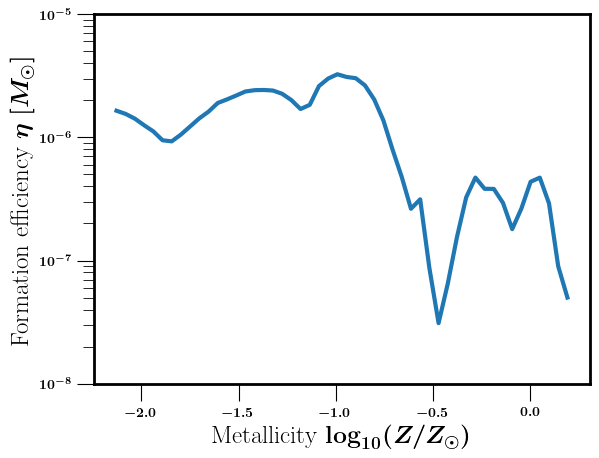

In [20]:
full_path = get_file_path(growl_catalog, "Boesky24", dataset="alpha0_1beta0_5")
df = pd.read_hdf(full_path, key="input_data")

# Inspect the available columns
print(df.columns)

formation_efficiency_per_solar_mass = df['formation_efficiency_per_solar_mass'].values
metallicities = df["metallicity"].values



# make a plot 

fs=18

hist, bin_edges = np.histogram(np.log10(metallicities/0.0142), weights=formation_efficiency_per_solar_mass, bins=50, density=True)

bin_centers = (bin_edges[0:-1] + bin_edges[1:])/2
normalization = np.sum(formation_efficiency_per_solar_mass)

plt.plot(bin_centers, hist*normalization, lw=3)


plt.yscale('log')
plt.ylim(10**-8, 10**-5)

plt.ylabel(r'Formation efficiency $\eta \ [M_{\odot}]$', fontsize=fs)
plt.xlabel(r'Metallicity $\log_{10}(Z/Z_{\odot})$', fontsize=fs)
plt.show()

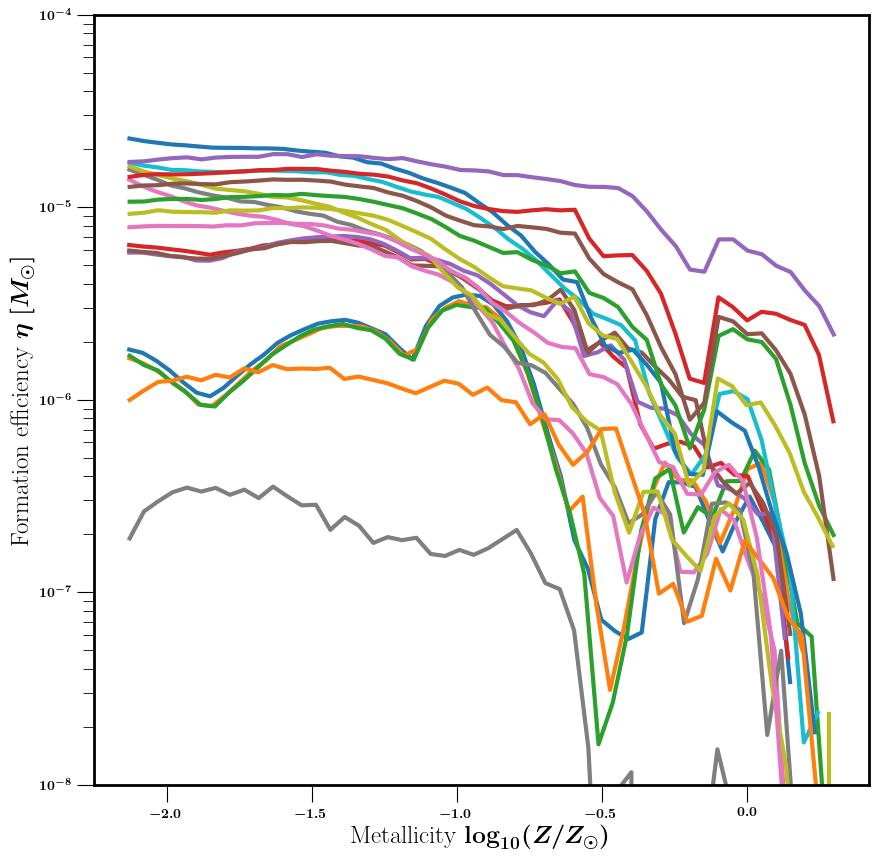

In [22]:
fs=18
f, ax= plt.subplots(ncols=1,nrows=1, figsize=(10,10))

for data_name in boesky_dataset_list:
    print('now at ', data_name)
    full_path = get_file_path(growl_catalog, "Boesky24", dataset=data_name)
    df = pd.read_hdf(full_path, key="input_data")

    formation_efficiency_per_solar_mass = df['formation_efficiency_per_solar_mass'].values
    metallicities = df["metallicity"].values



    # make a plot 
    hist, bin_edges = np.histogram(np.log10(metallicities/0.0142), weights=formation_efficiency_per_solar_mass, bins=50, density=True)

    bin_centers = (bin_edges[0:-1] + bin_edges[1:])/2
    normalization = np.sum(formation_efficiency_per_solar_mass)

    ax.plot(bin_centers, hist*normalization, lw=3, zorder=1)


ax.set_yscale('log')
ax.set_ylim(10**-8, 10**-4)
ax.set_grid(True, alpha=0.3, zorder=1)
ax.set_ylabel(r'Formation efficiency $\eta \ [M_{\odot}]$', fontsize=fs)
ax.set_xlabel(r'Metallicity $\log_{10}(Z/Z_{\odot})$', fontsize=fs)
plt.show()
